# FAKE NEWS Identification (kaggle)

Develop a machine learning program to identify when an article might be fake news.

train.csv: A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article; could be incomplete
* label: a label that marks the article as potentially unreliable
  * 1: unreliable
  * 0: reliable

test.csv: A testing training dataset with all the same attributes at train.csv without the label.

In [4]:
!pip install catboost

     |████████████████████████████████| 67.3MB 79kB/s 


In [5]:
# importing libraries 

import numpy as np 
import pandas as pd
import nltk
import re 
from nltk.corpus import stopwords 
nltk.download('stopwords')
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# reading data
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [8]:
train.shape, test.shape

((20800, 5), (5200, 4))

In [9]:
# checking null values 
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [10]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [12]:
# handling nan values using empty spaces
def handle_nan(train_data, test_data):
  '''input: data to the function containing nan values.
    output: cleaned data containing no nan values.
    function: cleaning the nan values.
  '''
  train = train_data.fillna(' ')
  test = test_data.fillna(' ')

  return train, test

train, test = handle_nan(train, test)

In [13]:
# creating a variable 'merged' by merging columns 'title' and 'author'
train['merged'] = train['title']+' '+train['author']
test['merged'] = test['title']+' '+test['author']

In [14]:
train.head()

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [15]:
# seperating independent and dependent variables 
x = train.drop(columns=['label'], axis=1)
y = train['label']

In [16]:
# creating one_hot representation 
messages = x.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

# Data Pre-processing
* In Data Pre-processing following steps are followed: 
  1. Firstly, all the sequences except english characters are removed from the string.
  2. Next, to avoid false predictions or ambiguity with upper and lowercase, all the characters in strings are converted    to lowercase.
  3. Next, all the sentences are tokenized into words.
  4. To facilitate fast processing, stemming is applied to the tokenized words.
  5. Next, words are joined together and stored in the corpus.

**Note: In this tutorial, we have used "merged" column for classification task. Also, the loop inside the function runs over all the examples in the merged column.**

In [17]:
# performing data preprocessing on column 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def perform_preprocess(data):
  '''Input: data to be preprocessed.
    output: preprocessed data.
  '''
  corpus = []

  for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['merged'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  return corpus

In [18]:
train_corpus = perform_preprocess(messages)
test_corpus = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [19]:
test_corpus[1]

'russian warship readi strike terrorist near aleppo'

Below code converts the preprocessed data to one_hot vectors in the range of vocabulary size of 5000, this is done to obtain numerical feature matrix.

In [22]:
# converting to one_hot representation
vocab_size = 5000
one_hot_train = [one_hot(word, vocab_size) for word in train_corpus]
one_hot_test = [one_hot(word, vocab_size) for word in test_corpus]

one_hot_train

[[4837, 150, 3148, 4939, 4773, 2380, 1237, 239, 375, 3821, 306, 3246],
 [1931, 3534, 2553, 1550, 3859, 4296, 657, 1299, 4633, 1931],
 [4059, 1567, 420, 12, 1076, 4275],
 [3083, 2201, 4905, 2141, 3896, 3437, 921, 976],
 [2556, 3859, 700, 2800, 4789, 418, 3859, 1442, 669, 4776, 1417, 4931],
 [4216,
  4962,
  4164,
  2063,
  1503,
  2081,
  2443,
  2252,
  2214,
  378,
  1700,
  3349,
  1636,
  459,
  657,
  1299,
  4299],
 [4822, 4822, 2157, 2827, 2923, 3878, 4505, 2740, 4613, 4214, 2497, 3495],
 [3239,
  3658,
  2650,
  169,
  606,
  4628,
  2165,
  3654,
  3834,
  270,
  2911,
  696,
  4633,
  4959],
 [62, 2525, 1382, 4863, 2081, 1941, 1201, 4534, 3888, 3000, 3834, 270, 2911],
 [31,
  3442,
  1760,
  803,
  1611,
  4187,
  2081,
  989,
  3834,
  270,
  2911,
  1662,
  3194,
  4111,
  478],
 [594, 1231, 756, 300, 2005, 2495, 1540, 2733, 2081, 927, 761, 1965],
 [1802, 2214, 1760, 2607, 4513, 2325, 3163, 768, 2020, 4792],
 [3752,
  2011,
  4133,
  4204,
  2495,
  3108,
  2051,
  2615,
  4

In [24]:
one_hot_test

[[704, 2081, 65, 235, 1921, 3683, 3753, 3798, 3834, 270, 2911, 1350, 2584],
 [3752, 3349, 4749, 969, 3423, 1808, 3576],
 [526, 1096, 3207, 4251, 553, 579, 977, 451, 3004, 1688, 3272, 3571],
 [3582, 65, 2991, 3588, 1259, 2911, 1913, 3834, 270, 2911, 1299, 175],
 [2954, 2695, 1393, 3185, 3550, 4059, 921, 109],
 [2081, 1276, 1438, 669, 2553, 3127, 2530],
 [1239, 4656, 1079, 4483, 800, 3752, 4863, 2081, 657, 685, 3047],
 [4008, 3683, 2237, 2304, 969, 3258, 2674],
 [2645, 3126, 3868, 3918, 4072, 2737, 1018],
 [3270, 2616],
 [4279, 3505, 2333, 4312, 2081, 3321, 3277, 1344, 4472],
 [96, 4836, 669, 2923, 1171, 2078, 3769],
 [3577, 4377, 104, 2904, 2115, 3333, 829, 3705, 511],
 [579, 770, 3447, 3791, 2862, 4400],
 [1384,
  3913,
  2209,
  4251,
  2561,
  2576,
  4264,
  444,
  4608,
  2081,
  1212,
  1276,
  3881,
  1276,
  2576,
  1777],
 [4321, 2638, 2003, 2737, 1516, 471, 3420, 3834, 270, 2911, 860, 2413],
 [3834,
  2907,
  2030,
  1789,
  3866,
  416,
  3160,
  2264,
  2186,
  2067,
  298,


Following code creaes an embedding layer which applies 'pre' padding to the one_hot encoded features with sentences length = 20. Padding is applied so that the length of every sequence in the dataset should be same.

In [25]:
# embedding
sent_length =20
embedded_dox_train = pad_sequences(one_hot_train, padding='pre', maxlen=sent_length)
embedded_dox_test = pad_sequences(one_hot_test, padding='pre', maxlen=sent_length)
embedded_dox_train

array([[   0,    0,    0, ..., 3821,  306, 3246],
       [   0,    0,    0, ..., 1299, 4633, 1931],
       [   0,    0,    0, ...,   12, 1076, 4275],
       ...,
       [   0,    0,    0, ...,  361,  627, 3962],
       [   0,    0,    0, ..., 1740, 1829, 4719],
       [   0,    0,    0, ..., 4990, 1350, 2671]], dtype=int32)

In [26]:
embedded_dox_test

array([[   0,    0,    0, ..., 2911, 1350, 2584],
       [   0,    0,    0, ..., 3423, 1808, 3576],
       [   0,    0,    0, ..., 1688, 3272, 3571],
       ...,
       [   0,    0,    0, ..., 2911, 2373,  597],
       [   0,    0,    0, ..., 3752, 4851, 2925],
       [   0,    0,    0, ..., 2911, 2797, 1880]], dtype=int32)

In [27]:
# conberting to array
x = np.array(embedded_dox_train)
y = np.array(y)
test = np.array(embedded_dox_test)

In [28]:
x.shape, y.shape, test.shape

((20800, 20), (20800,), (5200, 20))

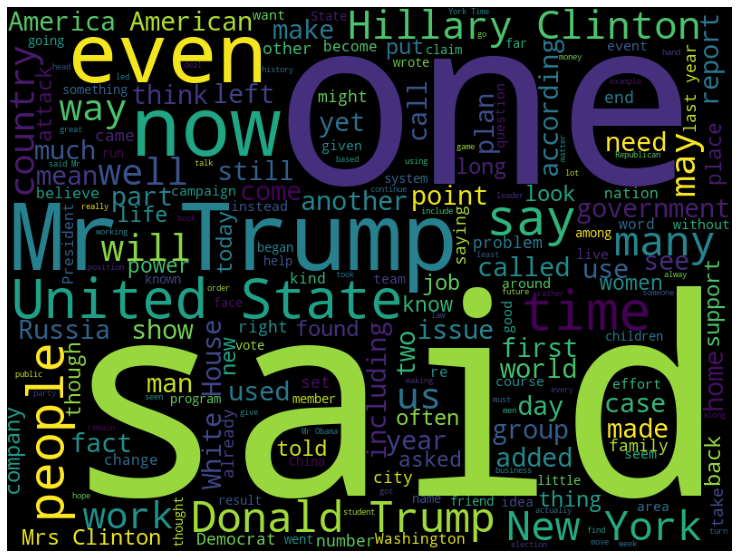

In [53]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=800, height=600)
wordcloud = wordcloud.generate(' '.join(train['text']))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
# splitting the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, 
                                                    random_state=4, stratify=y)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, 
                                                      test_size=0.1, random_state=4, 
                                                      stratify=y_train)

## Creating Models

### 1. Logistic Regression

In [31]:
model1 = LogisticRegression(max_iter=900)
model1.fit(X_train, Y_train)
pred1 = model1.predict(x_test)
cr1 = classification_report(y_test, pred1)
print(cr1) 

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1039
           1       0.74      0.72      0.73      1041

    accuracy                           0.74      2080
   macro avg       0.74      0.74      0.74      2080
weighted avg       0.74      0.74      0.73      2080



### 2. Naive Bayes

In [32]:
model2 = MultinomialNB()
model2.fit(X_train, Y_train)
pred2 = model2.predict(x_test)
cr2 = classification_report(y_test, pred2)
print(cr2)

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1039
           1       0.68      0.76      0.72      1041

    accuracy                           0.70      2080
   macro avg       0.71      0.70      0.70      2080
weighted avg       0.71      0.70      0.70      2080



### 3. Decision Tree

In [34]:
model3 = DecisionTreeClassifier()
model3.fit(X_train, Y_train)
pred3 = model3.predict(x_test)
cr3 = classification_report(y_test, pred3)
print(cr3)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1039
           1       0.94      0.93      0.94      1041

    accuracy                           0.94      2080
   macro avg       0.94      0.94      0.94      2080
weighted avg       0.94      0.94      0.94      2080



### 4. RandomForest

In [35]:
model4 = RandomForestClassifier()
model4.fit(X_train, Y_train)
pred4 = model4.predict(x_test)
cr4 = classification_report(y_test, pred4)
print(cr4)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1039
           1       0.89      0.97      0.92      1041

    accuracy                           0.92      2080
   macro avg       0.92      0.92      0.92      2080
weighted avg       0.92      0.92      0.92      2080



### 5. XGB

In [37]:
model5 = XGBClassifier()
model5.fit(X_train, Y_train)
pred5 = model5.predict(x_test)
cr5 = classification_report(y_test, pred5)
print(cr5)

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1039
           1       0.87      0.98      0.92      1041

    accuracy                           0.91      2080
   macro avg       0.92      0.91      0.91      2080
weighted avg       0.92      0.91      0.91      2080



### 6. Catboost

In [38]:
model6 = CatBoostClassifier(iterations=250)
model6.fit(X_train, Y_train)
pred6 = model6.predict(x_test)
cr6 = classification_report(y_test, pred6)
print(cr6)

Learning rate set to 0.122676
0:	learn: 0.5994557	total: 68.4ms	remaining: 17s
1:	learn: 0.5364391	total: 83.3ms	remaining: 10.3s
2:	learn: 0.4882035	total: 97.2ms	remaining: 8.01s
3:	learn: 0.4517117	total: 112ms	remaining: 6.87s
4:	learn: 0.4167815	total: 126ms	remaining: 6.18s
5:	learn: 0.4005897	total: 143ms	remaining: 5.81s
6:	learn: 0.3858571	total: 158ms	remaining: 5.49s
7:	learn: 0.3726553	total: 173ms	remaining: 5.22s
8:	learn: 0.3614060	total: 187ms	remaining: 5.01s
9:	learn: 0.3532765	total: 205ms	remaining: 4.92s
10:	learn: 0.3457751	total: 220ms	remaining: 4.78s
11:	learn: 0.3399629	total: 237ms	remaining: 4.7s
12:	learn: 0.3335951	total: 252ms	remaining: 4.59s
13:	learn: 0.3276036	total: 266ms	remaining: 4.48s
14:	learn: 0.3231742	total: 281ms	remaining: 4.4s
15:	learn: 0.3195951	total: 295ms	remaining: 4.32s
16:	learn: 0.3129471	total: 310ms	remaining: 4.24s
17:	learn: 0.3081207	total: 324ms	remaining: 4.18s
18:	learn: 0.3032816	total: 339ms	remaining: 4.12s
19:	learn: 0

### 7. LSTM

In this model, 
1. The value for embedding feature vectors = 40 which are target feature vectors for the embedding layer. 
2. Single LSTM Layer with 100 nodes are used. 
3.Dense Layer with 1 neuron and sigmoid activation function is used since, this is a binary classification problem. 
4. Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.

In [41]:
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size, embedding_feature_vector, input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
model.fit(X_train, Y_train, validation_data=(x_valid, y_valid), epochs=20, batch_size=64)

Epoch 1/20
264/264 [==============================] - 11s 33ms/step - loss: 0.3862 - accuracy: 0.8168 - val_loss: 0.0599 - val_accuracy: 0.9829
Epoch 2/20
264/264 [==============================] - 8s 31ms/step - loss: 0.0316 - accuracy: 0.9909 - val_loss: 0.0347 - val_accuracy: 0.9909
Epoch 3/20
264/264 [==============================] - 8s 31ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 0.0358 - val_accuracy: 0.9909
Epoch 4/20
264/264 [==============================] - 8s 31ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0387 - val_accuracy: 0.9893
Epoch 5/20
264/264 [==============================] - 8s 31ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0418 - val_accuracy: 0.9925
Epoch 6/20
264/264 [==============================] - 8s 31ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0465 - val_accuracy: 0.9925
Epoch 7/20
264/264 [==============================] - 8s 32ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0654 - val_accuracy: 0.984

In [44]:
# pred7 = np.argmax(model.predict(x_test), axis=-1)
pred7 = model.predict_classes(x_test)
cr7 = classification_report(y_test, pred7)
print(cr7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1039
           1       1.00      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080



### 8. Bidirectional LSTM

In [54]:
model8 = Sequential()
model8.add(Embedding(vocab_size, embedding_feature_vector, input_length=sent_length))
model8.add(Bidirectional(LSTM(100)))
model8.add(Dropout(0.3))
model8.add(Dense(1, activation='sigmoid'))
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model8.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
model8.fit(X_train, Y_train, validation_data=(x_valid, y_valid), epochs=20, batch_size=64)

Epoch 1/20
264/264 [==============================] - 18s 57ms/step - loss: 0.2781 - accuracy: 0.8642 - val_loss: 0.0475 - val_accuracy: 0.9834
Epoch 2/20
264/264 [==============================] - 13s 51ms/step - loss: 0.0190 - accuracy: 0.9943 - val_loss: 0.0418 - val_accuracy: 0.9877
Epoch 3/20
264/264 [==============================] - 14s 52ms/step - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0.0508 - val_accuracy: 0.9872
Epoch 4/20
264/264 [==============================] - 14s 52ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0554 - val_accuracy: 0.9882
Epoch 5/20
264/264 [==============================] - 14s 52ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0619 - val_accuracy: 0.9882
Epoch 6/20
264/264 [==============================] - 13s 50ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0766 - val_accuracy: 0.9861
Epoch 7/20
264/264 [==============================] - 14s 52ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0651 - val_accuracy:

In [57]:
pred8 = model8.predict_classes(x_test)
cr8 = classification_report(y_test, pred7)
print(cr8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1039
           1       1.00      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080



# Evaluating Models

In [58]:
score1 = accuracy_score(y_test, pred1)
score2 = accuracy_score(y_test, pred2)
score3 = accuracy_score(y_test, pred3)
score4 = accuracy_score(y_test, pred4)
score5 = accuracy_score(y_test, pred5)
score6 = accuracy_score(y_test, pred6)
score7 = accuracy_score(y_test, pred7)
score8 = accuracy_score(y_test, pred8)

results = pd.DataFrame([
                        ['LogisticRegression', score1],
                        ['NaiveBayes', score2],
                        ['DecisionTree', score3],
                        ['RandomForest', score4],
                        ['XGB', score5],
                        ['Catboost', score6],
                        ['LSTM', score7],
                        ['BidrectionalLSTM', score8]
])

results

,0,1
0,LogisticRegression,0.735096
1,NaiveBayes,0.703846
2,DecisionTree,0.935577
3,RandomForest,0.920673
4,XGB,0.912981
5,Catboost,0.982212
6,LSTM,0.991827
7,BidrectionalLSTM,0.992308


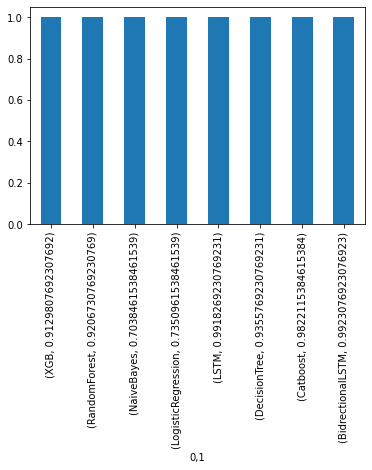

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
results.value_counts().plot.bar()

# Predictions on test data

In [59]:
raw_test = pd.read_csv('/content/sample_data/test.csv')
pred = pd.DataFrame(model8.predict_classes(test))
test_id = pd.DataFrame(raw_test['id'])
submission = pd.concat([test_id, pred], axis=1)
submission.columns = ['id', 'label']
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [60]:
submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
